# Implement Attention from Scratch

### Problem Statement

Implement a **Scaled Dot-Product Attention** mechanism from scratch using PyTorch. This core component is essential in Transformer architectures and helps models focus on relevant parts of a sequence.

### Background: Where Do Q, K, V Come From?

In a Transformer, Q (Query), K (Key), and V (Value) are **not separate inputs**. They all come from the **same input** (the residual stream) through learned linear projections:

```
x = input tensor (batch, seq_len, d_model)  # The residual stream

Q = x @ W_q  # Query projection
K = x @ W_k  # Key projection  
V = x @ W_v  # Value projection
```

This is called **self-attention** because the model attends to itself - the queries, keys, and values all come from the same source.

### The Math

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### Learning Path

1. **Part 1**: Core attention math (Q, K, V given) - isolate the mechanism
2. **Part 2**: Attention mask creation (causal, padding, combined, KV cache)
3. **Part 3**: Self-Attention class - Q, K, V from projections of single input x
4. **Part 4**: Visualizing attention patterns
5. **Part 5**: KV Cache for efficient inference

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Part 1: Core Attention Math

First, implement the core attention computation assuming Q, K, V are already given.
This isolates the attention mechanism itself.

In [2]:
torch.manual_seed(42)

batch_size = 2
seq_len = 8
d_k = 64

# For Part 1, we provide Q, K, V directly to focus on the attention math
q = torch.randn(batch_size, seq_len, d_k)
k = torch.randn(batch_size, seq_len, d_k)
v = torch.randn(batch_size, seq_len, d_k)

print(f"Q shape: {q.shape}")
print(f"K shape: {k.shape}")
print(f"V shape: {v.shape}")

Q shape: torch.Size([2, 8, 64])
K shape: torch.Size([2, 8, 64])
V shape: torch.Size([2, 8, 64])


In [3]:
from torch import einsum
from math import inf, sqrt
import torch.nn.functional as F


def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Compute scaled dot-product attention.

    Args:
        q: Query tensor of shape (batch, seq_len_q, d_k)
        k: Key tensor of shape (batch, seq_len_k, d_k)
        v: Value tensor of shape (batch, seq_len_k, d_v)
        mask: Optional boolean mask tensor where True indicates positions to mask out

    Returns:
        output: Attention output of shape (batch, seq_len_q, d_v)
        attention_weights: Attention weights of shape (batch, seq_len_q, seq_len_k)
    """
    d = q.shape[-1]
    A = torch.einsum("bsd,btd -> bst", [q, k])
    A /= sqrt(d)
    if mask is not None:
        A = torch.masked_fill(A, mask=mask, value=-inf)
    A = F.softmax(A, dim=-1)
    Av = torch.einsum("bst,btd -> bsd", [A, v])

    return Av, A

In [4]:
# Test against PyTorch's implementation
output_custom, attn_weights = scaled_dot_product_attention(q, k, v)
output_ref = F.scaled_dot_product_attention(q, k, v)

print(f"Output shape: {output_custom.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

assert torch.allclose(output_custom, output_ref, atol=1e-6), "Outputs don't match!"
print("\n\u2713 Core attention test passed!")

Output shape: torch.Size([2, 8, 64])
Attention weights shape: torch.Size([2, 8, 8])

✓ Core attention test passed!


## Part 2: Attention Mask Creation

Attention masks control which positions can attend to which other positions. Two common types:

1. **Causal Mask**: For autoregressive models (GPT, LLaMA), prevents attending to future tokens
2. **Padding Mask**: For batched sequences of different lengths, prevents attending to padding tokens

Mask convention: **True = masked (cannot attend), False = can attend**

This matches PyTorch's `masked_fill()` behavior directly.

### 2a. Causal Mask

A causal mask prevents attention to future positions - essential for autoregressive models like GPT.

In [5]:
def create_causal_mask(
    seq_len_q: int, seq_len_k: int = None, device=None
) -> torch.Tensor:
    """
    Create a causal (lower-triangular) attention mask for autoregressive models.

    In autoregressive generation, each position can only attend to previous positions
    (including itself). This prevents "looking into the future."

    Args:
        seq_len_q: Query sequence length
        seq_len_k: Key sequence length (defaults to seq_len_q)
        device: Device to create tensor on

    Returns:
        mask: Boolean tensor of shape (seq_len_q, seq_len_k)
              True = position should be MASKED (cannot attend)
              False = position can be attended to

    Example for seq_len=4:
        Q\\K   0      1      2      3
        0   [False, True,  True,  True ]   # Query 0 attends only to Key 0
        1   [False, False, True,  True ]   # Query 1 attends to Keys 0-1
        2   [False, False, False, True ]   # Query 2 attends to Keys 0-2
        3   [False, False, False, False]   # Query 3 attends to Keys 0-3
    """
    if seq_len_k is None:
        seq_len_k = seq_len_q
    mask = torch.ones((seq_len_q, seq_len_k))
    mask = torch.triu(mask, diagonal=1).to(bool)
    return mask

In [6]:
# Test causal mask creation
mask = create_causal_mask(4)
print("Causal mask (4x4):")
print(mask)
print("\nTrue = masked (cannot attend), False = can attend")

# Verify properties
assert mask.shape == (4, 4)
assert mask[0, 0] == False, "Position (0,0) should NOT be masked (can attend to self)"
assert mask[0, 1] == True, "Position (0,1) should be masked (cannot attend to future)"
assert mask[3, 0] == False, "Position (3,0) should NOT be masked (can attend to past)"
assert mask.sum() == 6, "Upper triangle should have 6 masked elements"

# Test with different Q/K lengths
mask_asymm = create_causal_mask(2, 4)
print(f"\nAsymmetric mask (2 queries, 4 keys):")
print(mask_asymm)
assert mask_asymm.shape == (2, 4)

print("\n\u2713 Causal mask test passed!")

Causal mask (4x4):
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

True = masked (cannot attend), False = can attend

Asymmetric mask (2 queries, 4 keys):
tensor([[False,  True,  True,  True],
        [False, False,  True,  True]])

✓ Causal mask test passed!


### 2b. Padding Mask

When batching sequences of different lengths, shorter sequences are padded. The padding tokens should not be attended to.

In [7]:
def create_padding_mask(lengths: torch.Tensor, max_len: int) -> torch.Tensor:
    """
    Create a padding mask for variable-length sequences in a batch.

    When batching sequences of different lengths, shorter sequences are padded.
    The padding tokens should not be attended to.

    Args:
        lengths: Tensor of shape (batch_size,) containing actual sequence lengths
        max_len: Maximum sequence length (padded length)

    Returns:
        mask: Boolean tensor of shape (batch_size, max_len)
              True = padding position (should be MASKED)
              False = real token (can be attended to)

    Example:
        lengths = [3, 5, 2], max_len = 5

        Returns:
        [[False, False, False, True,  True ],   # seq 0: tokens 0-2 real, 3-4 padding
         [False, False, False, False, False],   # seq 1: all 5 tokens real
         [False, False, True,  True,  True ]]   # seq 2: tokens 0-1 real, 2-4 padding
    """
    return (
        torch.arange(max_len)[None, :] >= lengths[:, None]
    )  # (1, m) >= (b, 1) -> ([[0,1,...max_len],...[0,1,...max_len]])>=([[a,b,...,m],[c,d,...,n]]) -> (b, m)

In [8]:
lengths = torch.tensor([3, 5, 2])
max_len = 5
torch.arange(max_len)[None, :] >= lengths[:, None]

tensor([[False, False, False,  True,  True],
        [False, False, False, False, False],
        [False, False,  True,  True,  True]])

In [9]:
# Test padding mask creation
lengths = torch.tensor([3, 5, 2])
mask = create_padding_mask(lengths, max_len=5)
print("Padding mask (batch=3, max_len=5):")
print(f"Sequence lengths: {lengths.tolist()}")
print(mask)

# Verify
assert mask.shape == (3, 5)
assert mask[0].tolist() == [False, False, False, True, True]
assert mask[1].tolist() == [False, False, False, False, False]
assert mask[2].tolist() == [False, False, True, True, True]

print("\n\u2713 Padding mask test passed!")

Padding mask (batch=3, max_len=5):
Sequence lengths: [3, 5, 2]
tensor([[False, False, False,  True,  True],
        [False, False, False, False, False],
        [False, False,  True,  True,  True]])

✓ Padding mask test passed!


### 2c. Combined Attention Mask

In practice, you often need both causal masking AND padding masking together.

In [10]:
import torch


def create_attention_mask(
    seq_len_q: int,
    seq_len_k: int = None,
    is_causal: bool = True,
    key_padding_lengths: torch.Tensor = None,
    device=None,
) -> torch.Tensor:
    """
    Create a combined attention mask handling both causality and padding.

    Args:
        seq_len_q: Query sequence length
        seq_len_k: Key sequence length
        is_causal: Whether to apply causal masking
        key_padding_lengths: If provided, actual lengths of key sequences (batch_size,)
        device: Device to create tensor on

    Returns:
        mask: Boolean tensor, True = masked position
              Shape: (seq_len_q, seq_len_k) if no padding
              Shape: (batch_size, seq_len_q, seq_len_k) if padding provided
    """
    # causal mask
    if seq_len_k is None:
        seq_len_k = seq_len_q
    mask = torch.ones((seq_len_q, seq_len_k), dtype=torch.bool, device=device)
    if not is_causal and key_padding_lengths is None:
        return mask
    mask = torch.triu(mask, diagonal=1)
    if is_causal and key_padding_lengths is None:
        return mask

    # padding mask
    max_len = seq_len_k
    padding_mask = (
        torch.arange(max_len, device=device)[None, :] >= key_padding_lengths[:, None]
    )  # (batch_size, max_len)
    if not is_causal:
        return padding_mask.to(device)

    # make out, a (batch_size, seq_len_q, max_len) tensor.
    # only the first key_padding_lengths[i] columns should be unmasked for out[i, ...]
    out = padding_mask[:, None, :] | mask[None, :, :]

    return out


In [11]:
# Test combined mask: causal only
mask_causal = create_attention_mask(4, is_causal=True)
print("Causal-only mask:")
print(mask_causal)

# Test combined mask: causal + padding
lengths = torch.tensor([4, 3])  # batch of 2, one full, one with padding
mask_combined = create_attention_mask(4, is_causal=True, key_padding_lengths=lengths)
print(f"\nCombined causal + padding mask (batch=2):")
print(f"Key lengths: {lengths.tolist()}")
print(f"Batch 0 (full length):")
print(mask_combined[0])
print(f"Batch 1 (length=3, position 3 is padding):")
print(mask_combined[1])

# Verify batch 1 has position 3 masked for all queries
assert mask_combined[1, :, 3].all(), "Padding position should be masked for all queries"

print("\n\u2713 Combined mask test passed!")

Causal-only mask:
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

Combined causal + padding mask (batch=2):
Key lengths: [4, 3]
Batch 0 (full length):
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])
Batch 1 (length=3, position 3 is padding):
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False,  True]])

✓ Combined mask test passed!


### 2d. Causal Mask with KV Cache

During autoregressive generation with KV cache, the mask needs special handling:
- New queries can attend to ALL cached positions (they're in the past)
- Causal masking only applies within the new tokens

In [12]:
import torch


def create_causal_mask_with_cache(
    seq_len_q: int, seq_len_k: int, cache_len: int, device=None
) -> torch.Tensor:
    """
    Create a causal mask for attention with KV cache.

    During autoregressive generation with KV cache:
    - Query has only new tokens (usually 1 during generation)
    - Keys include cached tokens + new tokens
    - New queries can attend to ALL cached keys (they're in the past)

    Args:
        seq_len_q: Number of new query tokens (typically 1 during generation)
        seq_len_k: Total key length (cache_len + seq_len_q)
        cache_len: Number of cached tokens
        device: Device to create tensor on

    Returns:
        mask: Boolean tensor of shape (seq_len_q, seq_len_k)

    Example: cache_len=3, seq_len_q=2, seq_len_k=5
        Keys:    [cached0, cached1, cached2, new0, new1]

        Q\\K      c0     c1     c2    new0   new1
        new0  [False, False, False, False, True ]  # new0 attends to cache + itself
        new1  [False, False, False, False, False]  # new1 attends to cache + new0 + itself
    """
    mask = torch.ones((seq_len_q, seq_len_k), device=device)
    diagonal = (
        cache_len + 1
    )  # dont mask any of the cache, don't mask token attn to itself
    mask = torch.triu(mask, diagonal=diagonal).to(dtype=torch.bool)
    return mask


In [13]:
# Test KV cache mask: single token generation (most common case)
mask_single = create_causal_mask_with_cache(seq_len_q=1, seq_len_k=5, cache_len=4)
print("KV cache mask (1 new token, 4 cached):")
print(f"Shape: {mask_single.shape}")
print(mask_single)
assert mask_single[0].tolist() == [False, False, False, False, False], (
    "Single new token can attend to all"
)

# Test KV cache mask: multi-token (prefill or speculative decoding)
mask_multi = create_causal_mask_with_cache(seq_len_q=3, seq_len_k=6, cache_len=3)
print("\nKV cache mask (3 new tokens, 3 cached):")
print(f"Keys: [cached0, cached1, cached2, new0, new1, new2]")
print(mask_multi)
# new0 can attend to cache + itself
assert mask_multi[0].tolist() == [False, False, False, False, True, True]
# new2 can attend to everything
assert mask_multi[2].tolist() == [False, False, False, False, False, False]

# Test prefill (no cache)
mask_prefill = create_causal_mask_with_cache(seq_len_q=3, seq_len_k=3, cache_len=0)
print("\nPrefill mask (3 tokens, no cache):")
print(mask_prefill)
assert mask_prefill[0, 1] == True, "First query can't see second"
assert mask_prefill[2, 0] == False, "Third query can see first"

print("\n\u2713 KV cache mask test passed!")

KV cache mask (1 new token, 4 cached):
Shape: torch.Size([1, 5])
tensor([[False, False, False, False, False]])

KV cache mask (3 new tokens, 3 cached):
Keys: [cached0, cached1, cached2, new0, new1, new2]
tensor([[False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])

Prefill mask (3 tokens, no cache):
tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

✓ KV cache mask test passed!


### Test Masks with Attention

Now let's verify our masks work correctly with the attention function.

In [14]:
# Test causal mask with attention
torch.manual_seed(42)
q_test = torch.randn(batch_size, seq_len, d_k)
k_test = torch.randn(batch_size, seq_len, d_k)
v_test = torch.randn(batch_size, seq_len, d_k)

causal_mask = create_causal_mask(seq_len)
output_masked, attn_weights_masked = scaled_dot_product_attention(
    q_test, k_test, v_test, mask=causal_mask
)

# Verify upper triangle is zero (no attention to future tokens)
upper_triangle = attn_weights_masked[0].triu(diagonal=1)
assert torch.allclose(upper_triangle, torch.zeros_like(upper_triangle), atol=1e-6), (
    "Causal mask failed! Positions are attending to future tokens."
)

# Verify each row sums to 1
row_sums = attn_weights_masked.sum(dim=-1)
assert torch.allclose(row_sums, torch.ones_like(row_sums), atol=1e-6), (
    "Attention weights don't sum to 1!"
)

# Compare against PyTorch's is_causal
output_ref = F.scaled_dot_product_attention(q_test, k_test, v_test, is_causal=True)
assert torch.allclose(output_masked, output_ref, atol=1e-6), (
    "Doesn't match PyTorch is_causal!"
)

print("\u2713 Causal attention test passed!")
print("\nAttention weights (notice upper triangle is 0):")
print(attn_weights_masked[0].round(decimals=2))

✓ Causal attention test passed!

Attention weights (notice upper triangle is 0):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3300, 0.6700, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.4300, 0.4700, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1200, 0.0600, 0.0100, 0.8100, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0400, 0.0100, 0.0400, 0.8300, 0.0900, 0.0000, 0.0000, 0.0000],
        [0.0800, 0.0500, 0.1000, 0.5000, 0.2300, 0.0400, 0.0000, 0.0000],
        [0.0200, 0.1200, 0.3800, 0.2500, 0.0500, 0.1600, 0.0200, 0.0000],
        [0.1400, 0.0300, 0.0800, 0.0200, 0.0600, 0.4000, 0.0800, 0.1900]])


## Part 3: Self-Attention with Projections

Now implement **actual self-attention** where Q, K, V come from learned projections of a single input x.

This is how attention works in real Transformers:
- Input: `x` (batch, seq_len, d_model) - the residual stream
- Q, K, V are computed as `x @ W_q`, `x @ W_k`, `x @ W_v`
- Output projection: `attention_output @ W_o`

In [15]:
import torch
from math import sqrt
import torch.nn.functional as F


class SelfAttention(nn.Module):
    """
    Self-Attention layer where Q, K, V come from projections of the same input.

    This is how attention actually works in Transformers - the input x
    (the residual stream) is projected to create Q, K, and V.
    """

    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.QKV = nn.Linear(d_model, 3 * d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(
        self,
        x: torch.Tensor,
        is_causal: bool = False,
        key_padding_lengths: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        Args:
            x: Input tensor (batch, seq_len, d_model) - the residual stream
            is_causal: Whether to apply causal masking
            key_padding_lengths: If provided, actual lengths for padding mask

        Returns:
            output: Self-attention output (batch, seq_len, d_model)
        """
        qkv: torch.Tensor = self.QKV(x)  # (batch, seq_len, 3*d_model)
        q, k, v = qkv.chunk(3, dim=-1)  # 3 x (batch, seq_len, d_model)
        b, s, d = q.shape
        t = k.shape[1]

        # self-attention matrix
        a = torch.einsum("bsd, btd -> bst", [q, k]) / sqrt(self.d_model)
        if is_causal:  # make causal mask
            mask = torch.triu(torch.ones_like(a), diagonal=1).to(torch.bool)
            a = torch.masked_fill(a, mask, float("-inf"))
        if key_padding_lengths is not None:
            # build mask of key padding lengths for every batch
            assert len(key_padding_lengths) == b
            max_len = t
            padding_mask = (
                key_padding_lengths[:, None]
                <= torch.arange(max_len, device=x.device)[None, :]
            )  # (b, 1) > (1, t): (b, t)
            padding_mask = padding_mask[:, None, :]  # (b, 1, t)
            a = a.masked_fill(padding_mask, float("-inf"))

        a = F.softmax(a, dim=-1)
        av = torch.einsum("bst, btd -> bsd", [a, v])
        return self.out_proj(av)


In [16]:
# Test Self-Attention
torch.manual_seed(42)

batch_size = 2
seq_len = 8
d_model = 64

# Single input - the residual stream
x = torch.randn(batch_size, seq_len, d_model)
print(f"Input x shape: {x.shape}")
print("This single input x will be projected to create Q, K, and V")

# Create self-attention layer
self_attn = SelfAttention(d_model)

# Forward pass (bidirectional)
output = self_attn(x)
print(f"\nOutput shape: {output.shape}")
assert output.shape == x.shape, "Output shape should match input shape!"

# Forward pass (causal)
output_causal = self_attn(x, is_causal=True)
print(f"Causal output shape: {output_causal.shape}")

# Forward pass (with padding)
lengths = torch.tensor([8, 5])  # second sequence is shorter
output_padded = self_attn(x, is_causal=True, key_padding_lengths=lengths)
print(f"Padded output shape: {output_padded.shape}")

print("\n\u2713 Self-Attention test passed!")

Input x shape: torch.Size([2, 8, 64])
This single input x will be projected to create Q, K, and V

Output shape: torch.Size([2, 8, 64])
Causal output shape: torch.Size([2, 8, 64])
Padded output shape: torch.Size([2, 8, 64])

✓ Self-Attention test passed!


## Part 4: Visualizing Attention Patterns

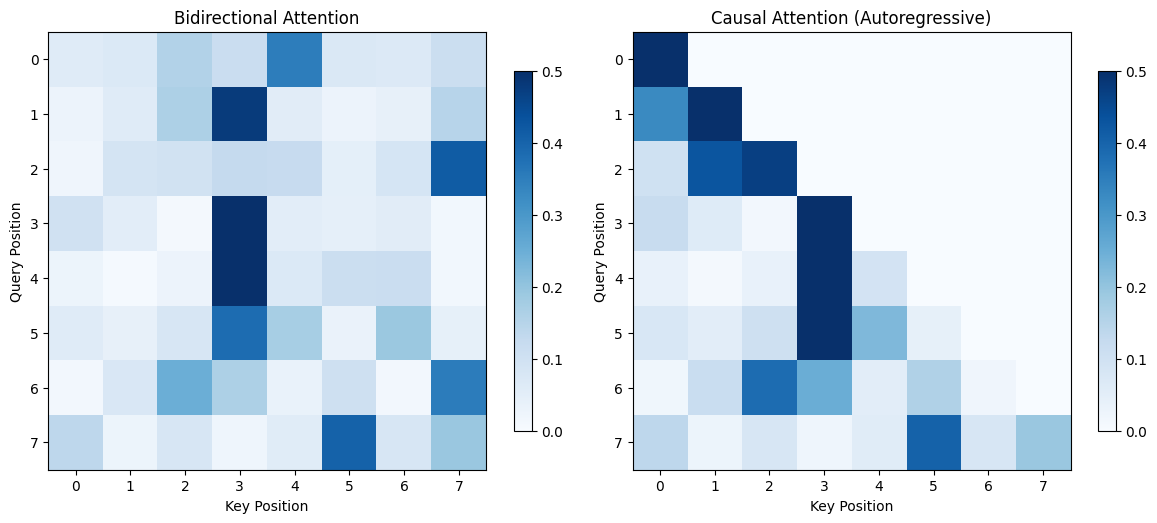

Notice how causal attention has zeros in the upper triangle -
each position can only attend to itself and earlier positions.


In [17]:
import matplotlib.pyplot as plt

# Get attention weights for both bidirectional and causal attention
_, attn_bidirectional = scaled_dot_product_attention(q_test, k_test, v_test, mask=None)
_, attn_causal = scaled_dot_product_attention(
    q_test, k_test, v_test, mask=create_causal_mask(seq_len)
)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(
    attn_bidirectional[0].detach().numpy(), cmap="Blues", vmin=0, vmax=0.5
)
axes[0].set_title("Bidirectional Attention", fontsize=12)
axes[0].set_xlabel("Key Position")
axes[0].set_ylabel("Query Position")
plt.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(attn_causal[0].detach().numpy(), cmap="Blues", vmin=0, vmax=0.5)
axes[1].set_title("Causal Attention (Autoregressive)", fontsize=12)
axes[1].set_xlabel("Key Position")
axes[1].set_ylabel("Query Position")
plt.colorbar(im2, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.savefig("attention_patterns.png", dpi=150, bbox_inches="tight")
plt.show()

print("Notice how causal attention has zeros in the upper triangle -")
print("each position can only attend to itself and earlier positions.")

## Part 5: Self-Attention with KV Cache

### Why KV Cache?

During autoregressive generation:
- Without cache: Recompute K, V for ALL tokens at every step → O(n²)
- With cache: Only compute K, V for NEW token, concatenate with cache → O(n)

### Key Insight

We cache the **projected** K and V values (after `W_k(x)` and `W_v(x)`).
For each new token, we:
1. Compute Q, K, V from the new token's x
2. Concatenate new K, V with cached K, V
3. Compute attention using full K, V but only new Q

In [ ]:
class SelfAttentionWithCache(nn.Module):
    """
    Self-Attention with KV Cache for efficient autoregressive generation.
    """

    def __init__(self, d_model: int):
        super().__init__()
        pass

    def forward(
        self,
        x: torch.Tensor,
        cache_k: torch.Tensor = None,
        cache_v: torch.Tensor = None,
        is_causal: bool = True,
    ) -> tuple:
        """
        Args:
            x: Input tensor (batch, seq_len, d_model)
            cache_k: Cached keys (batch, cached_len, d_model) or None
            cache_v: Cached values (batch, cached_len, d_model) or None
            is_causal: Whether to apply causal masking (default True for autoregressive)

        Returns:
            output: Attention output (batch, seq_len, d_model)
            new_cache_k: Updated key cache
            new_cache_v: Updated value cache
        """
        pass

In [ ]:
# Test Self-Attention with KV Cache
print("=== Testing Self-Attention with KV Cache ===")

torch.manual_seed(42)
batch_size = 2
d_model = 64

self_attn_cached = SelfAttentionWithCache(d_model)

# Step 1: Process prompt (3 tokens) - prefill
prompt = torch.randn(batch_size, 3, d_model)
print(f"\nInput prompt shape: {prompt.shape}")
print("Q, K, V will all be computed from this single input via learned projections")

out1, cache_k, cache_v = self_attn_cached(prompt, None, None)
print(f"\nAfter prompt: cache shape = {cache_k.shape}")

# Step 2: Generate token 4 (single new token)
new_token = torch.randn(batch_size, 1, d_model)
out2, cache_k, cache_v = self_attn_cached(new_token, cache_k, cache_v)
print(f"After token 4: cache shape = {cache_k.shape}")

# Step 3: Generate token 5
new_token = torch.randn(batch_size, 1, d_model)
out3, cache_k, cache_v = self_attn_cached(new_token, cache_k, cache_v)
print(f"After token 5: cache shape = {cache_k.shape}")

# Verify
assert cache_k.shape == (batch_size, 5, d_model)
assert out3.shape == (batch_size, 1, d_model)

print("\n\u2713 Self-Attention with KV Cache test passed!")
print("\nKey insight: Each generation step only computes K, V for 1 new token,")
print("but attends over ALL previous tokens via the cache.")

## Interview Tips

**Q: Where do Q, K, V come from in self-attention?**
A: All three come from learned linear projections of the same input x (the residual stream): Q = W_q(x), K = W_k(x), V = W_v(x).

**Q: What's the difference between self-attention and cross-attention?**
A: In self-attention, Q, K, V come from the same input. In cross-attention (like encoder-decoder), Q comes from one source (decoder) while K, V come from another (encoder output).

**Q: Why scale by sqrt(d_k)?**
A: To prevent dot products from growing too large with high dimensions, which would push softmax into regions with tiny gradients.

**Q: How do you create a causal mask?**
A: Use `torch.triu(..., diagonal=1)` to create a boolean upper triangular matrix where True = masked. The upper triangle blocks attention to future positions.

**Q: How do you handle padding in attention?**
A: Create a padding mask where positions >= sequence length are True (masked). Combine with causal mask using OR operation.

**Q: What is KV cache and why is it used?**
A: KV cache stores computed K, V from previous tokens during autoregressive generation. Without it, generating n tokens requires O(n²) computations; with it, only O(n).

**Q: How does masking work with KV cache?**
A: New queries can attend to all cached positions (they're in the past). Causal masking only applies within the new tokens. Use `create_causal_mask_with_cache()` with the cache length offset.

**Q: What happens during prefill vs decode phases?**
A: 
- Prefill: Process entire prompt at once, populate cache (compute-bound)
- Decode: Generate one token at a time using cache (memory-bound)